In [1]:
from core.models import (
    BivariateOUProcess, 
    BivariateCorrelatedBM, 
    BivariateCorrelatedDiffusion, 
    BivariateNonHomogeneous, 
    Fourier4
)
from attributes.attributes import *
from core.MultipleHypTest import MultipleHypTest
from core.main import (
    Test,
    TestV2,
    Container,
    Kernel,
    running_maximum,
    graph,
    simulate,
    NoReturn,
    simple_sequence,
    tqdm,
    repl
)

from Data.Reader import Reader
from ContextManager.ModuleContextManager import ImportContextManager
from ContextManager.ModuleContextManager import init_function
from ContextManager.ModuleContextManager import cleanup_function

In [2]:
def Reload(mod) -> type(...) | NoReturn: 
    with ImportContextManager('importlib', init_func=init_function, cleanup_func=cleanup_function) as _f: _f.reload(mod)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TODO
1. Change `main.Test().Gauss()` to use the Fan-Fan-Yiang asymptotic variance.
2. Debug `Reload(mod) -> type(...) | NoReturn`
3. Comment on `simple_sequence(...)`

# Processes
Let us start by defining the processes

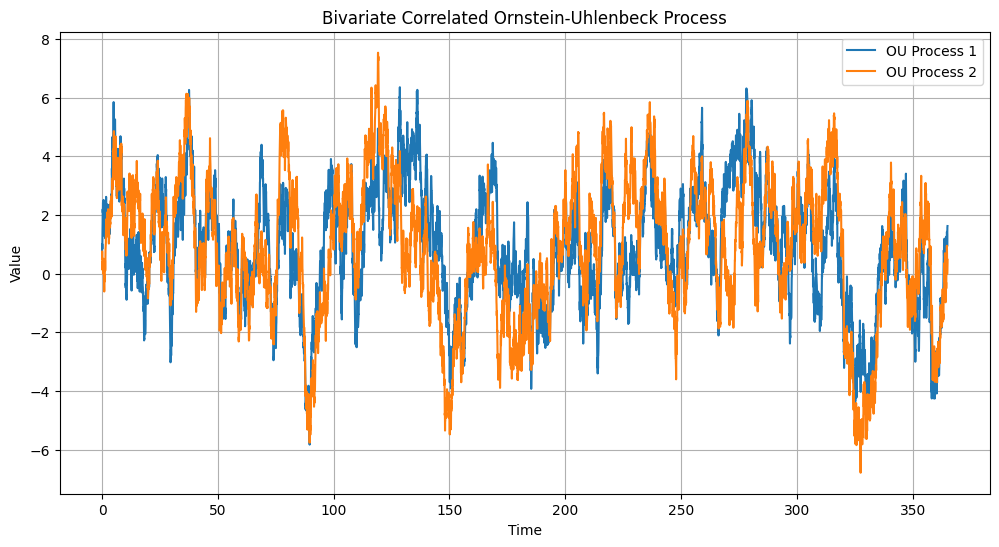

In [4]:
ou_config = {'T':365, 'dt': 1 / 20, 'sigma1': np.sqrt(2), 'sigma2': np.sqrt(2), 'theta1':.2, 'theta2':.2, 'rho':.75}
ou_process = BivariateOUProcess(**ou_config)
ou_process.simulate(seed=1)
ou_process.plot()

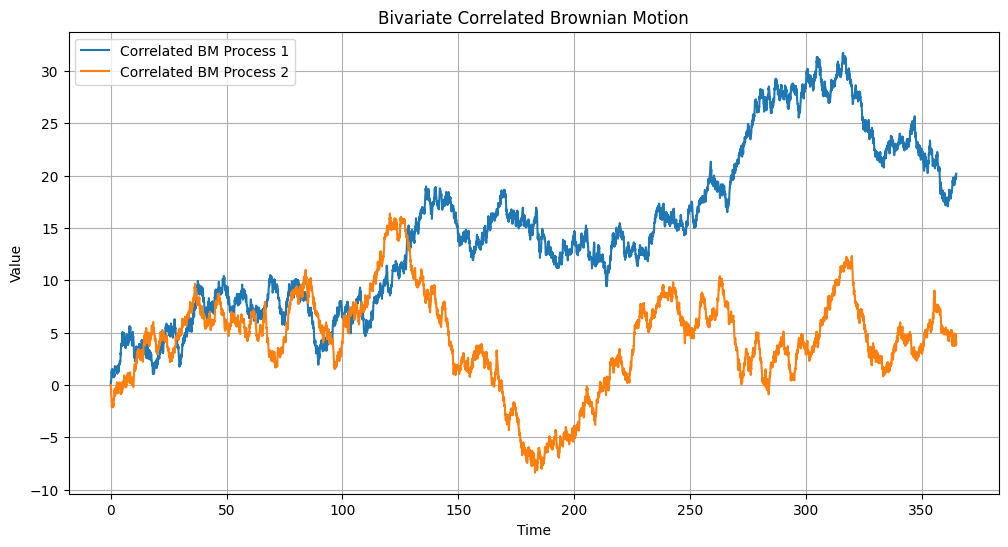

In [5]:
bw_config = {'T':365, 'dt': 1 / 20,'mu1': 0.0, 'mu2': 0.0, 'rho': .0, 'sigma1': 1, 'sigma2': 1}
bw_process = BivariateCorrelatedBM(**bw_config)
bw_process.simulate(seed=1)
bw_process.plot()

In [31]:
# df_config_null = {'T':365, 'dt': 1 / 20,'mu1': 0.0, 'mu2': 0.0, 'rho': 0, 'sigma1': 1, 'sigma2': 1, 'gamma': .6}
# df_process_null = BivariateCorrelatedDiffusion(**df_config_null)
# df_process_null.simulate(seed=1)
# df_process_null.plot()

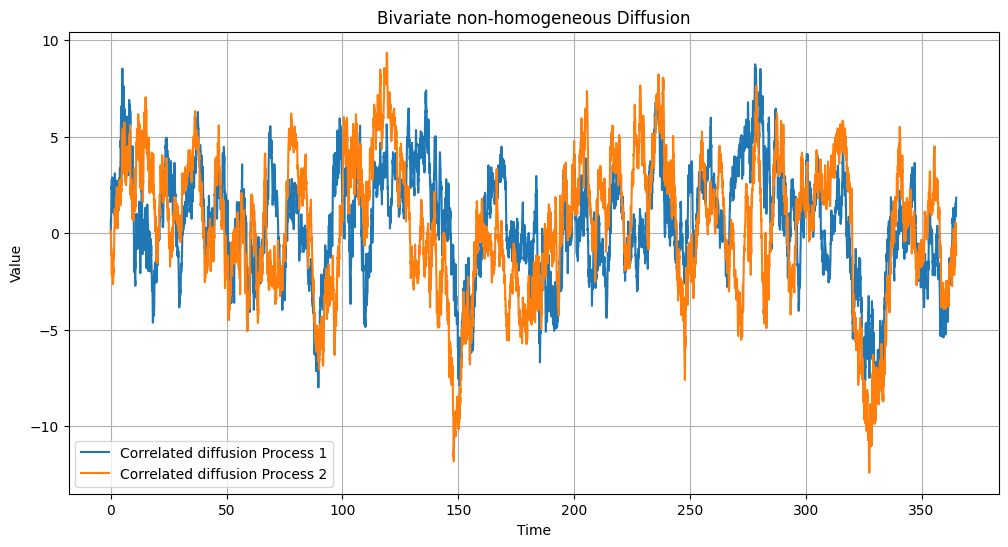

In [38]:
nh_config = {'T':365, 'dt': 1 / 20, 'rho': .5, 'alpha':.5, 'b':.1}
nh_process = BivariateNonHomogeneous(**nh_config)
nh_process.simulate(seed=1)
nh_process.plot()

# Testing
We run the test

In [8]:
X, T, n = ou_process.config()
config_ou_est: dict = {
    'data'  : X,
    'kernel_params' : {
        'bandwidth' : 3 / ((n ** (1 / 5))),
        'n'         : n,
        'T'         : T,
        'kernel'    : Kernel.BaseKernel
    },
    'time_params'   : {
        'bandwidth' : 200 * T / n,
        'n'         : n,
        'T'         : T
    },
}

In [9]:
stationarity_test = TestV2(**config_ou_est)

data :: Ornstein Uhlenbeck
kernel_params
 bandwidth :: 0.5063568420725781
         n :: 7300
         T :: 365
    kernel :: <function Kernel.BaseKernel at 0x000001D211D2E5F0>
time_params
 bandwidth :: 10.0
         n :: 7300
         T :: 365
   disable :: False
 reachable :: False
       use :: root
kernel_estimates
time_estimates


In [10]:
s = ou_config['sigma1'] ** 2 / (2 * ou_config['theta1'])
f_leb = lambda x, t : (1 / np.sqrt(2 * np.pi * s)) * np.exp(- (x ** 2) / (2 * s))
t_leb = np.linspace(0, ou_process.T, ou_process.N)
dist = (f_leb(X['process 1'], t_leb) * f_leb(X['process 2'], t_leb)).tolist()

In [11]:
stationarity_test.time_domain_smoother(lamb = .99)
stationarity_test.state_domain_smoother(dist = True)
stationarity_test.gauss()

bound, scalar_gauss = stationarity_test.transform_1D_gauss()

100%|██████████| 7300/7300 [00:29<00:00, 243.67it/s]


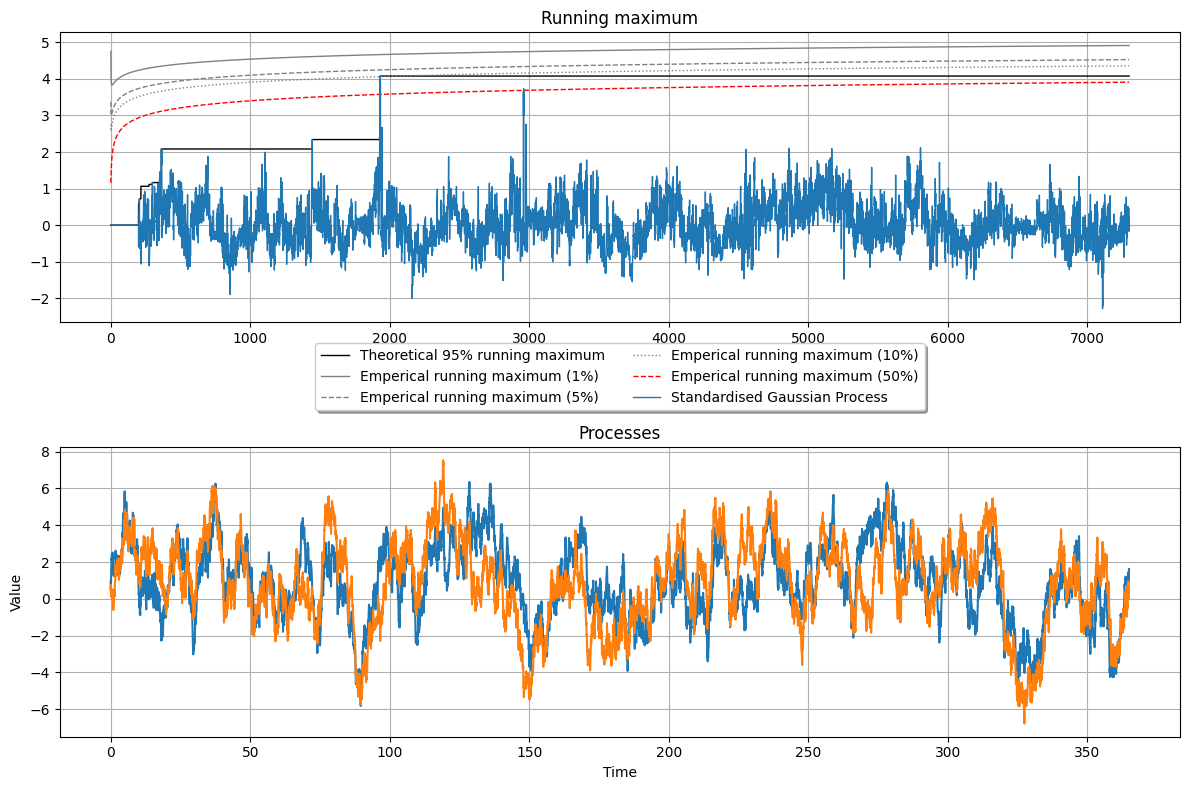

In [12]:
plotting_lib = graph(stationarity_test)
plotting_lib.plot_running_maximum()

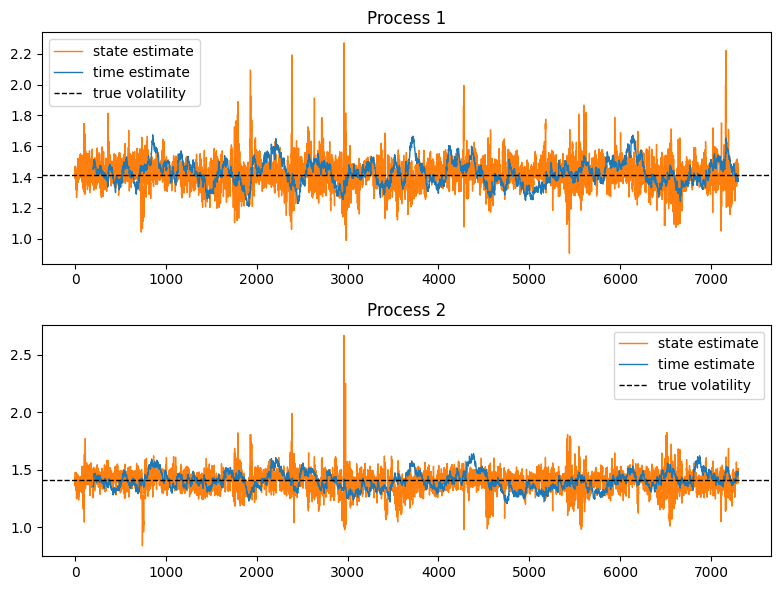

In [13]:
est_time = stationarity_test.time_estimates['estimate']
var_time = stationarity_test.time_estimates['variance']

est_state = stationarity_test.kernel_estimates['estimate']
var_state = stationarity_test.kernel_estimates['variance']

fig, axs = plt.subplots(2,1, figsize = (8,6))
axs[0].plot([item.item(0) ** .5 for item in est_state], c = 'C1', ls = '-', lw = 1, label = 'state estimate')
# plt.plot([item.item(1) ** .5 for item in est_state], c = 'C1', ls = 'dashed', lw = 1)
axs[1].plot([item.item(3) ** .5 for item in est_state], c = 'C1', ls = '-', lw = 1, label = 'state estimate')
axs[0].plot([item.item(0) ** .5 for item in est_time], c = 'C0', ls = '-', lw = 1, label = 'time estimate')
axs[0].axhline(ou_config['sigma1'], c = 'black', ls = '--', lw = 1, label = 'true volatility')
# plt.plot([item.item(1) ** .5 for item in est_time], c = 'C0', ls = 'dashed', lw = 1)
axs[1].plot([item.item(3) ** .5 for item in est_time], c = 'C0', ls = '-', lw = 1, label = 'time estimate')
axs[1].axhline(ou_config['sigma2'], c = 'black', ls = '--', lw = 1, label = 'true volatility')
axs[0].set_title('Process 1')
axs[1].set_title('Process 2')
for ax in axs: ax.legend()
fig.tight_layout()
plt.show()

In [14]:
X, T, n = bw_process.config()
config_bw_est: dict = {
    'data'  : X,
    'kernel_params' : {
        'bandwidth' : 3 / ((n ** (1 / 5))),
        'n'         : n,
        'T'         : T,
        'kernel'    : Kernel.BaseKernel
    },
    'time_params'   : {
        'bandwidth' : 200 * T / n,
        'n'         : n,
        'T'         : T
    },
}

In [15]:
stationarity_test = TestV2(**config_bw_est)

data :: Correlated Brownian motion
kernel_params
 bandwidth :: 0.5063568420725781
         n :: 7300
         T :: 365
    kernel :: <function Kernel.BaseKernel at 0x000001D211D2E5F0>
time_params
 bandwidth :: 10.0
         n :: 7300
         T :: 365
   disable :: False
 reachable :: False
       use :: root
kernel_estimates
time_estimates


In [16]:
f_leb = lambda x, t : (1 / np.sqrt(2 * np.pi * t)) * np.exp(- (x ** 2) / (2 * t))
t_leb = np.linspace(0, bw_process.T, bw_process.N)
dist = (f_leb(X['process 1'], t_leb) * f_leb(X['process 2'], t_leb)).tolist()
dist = (np.ones_like(t_leb) / 50).tolist()

In [17]:
stationarity_test.time_domain_smoother(lamb = .99)
stationarity_test.state_domain_smoother(dist = dist)
stationarity_test.gauss()

bound, scalar_gauss = stationarity_test.transform_1D_gauss()

100%|██████████| 7300/7300 [00:18<00:00, 396.48it/s]


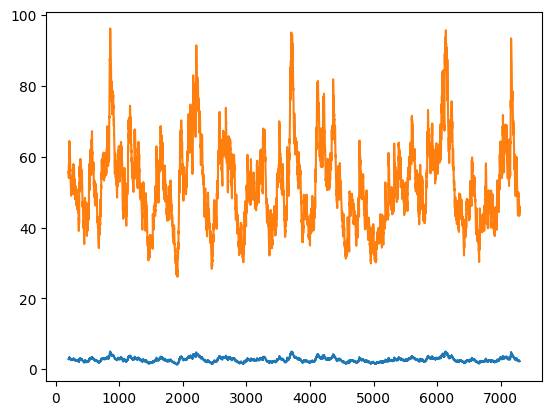

In [18]:
plt.plot([item.item(0) for item in stationarity_test.time_estimates['variance']])
plt.plot([item.item(0) for item in stationarity_test.kernel_estimates['variance']])

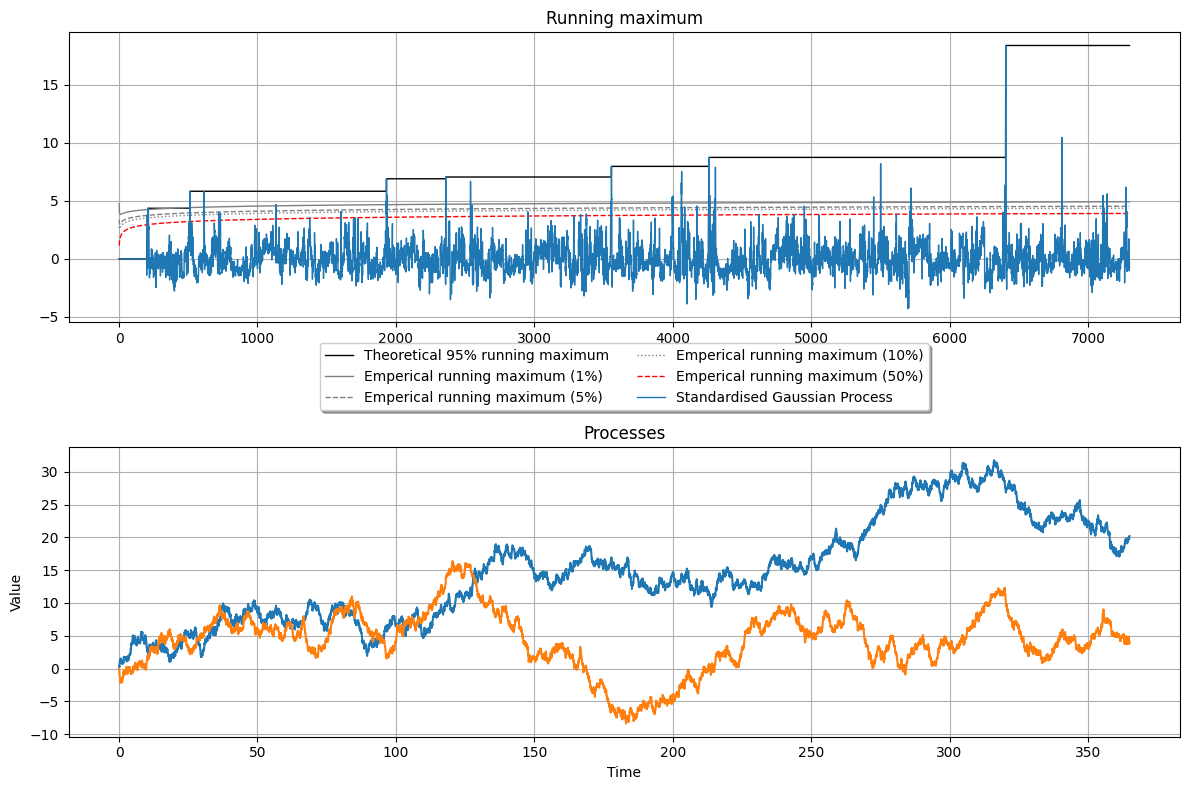

In [19]:
plotting_lib = graph(stationarity_test)
plotting_lib.plot_running_maximum()

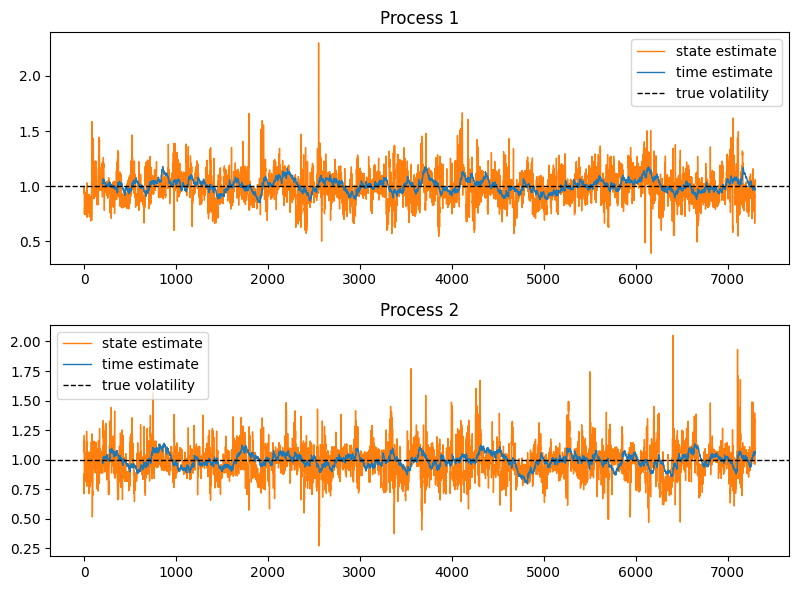

In [20]:
est_time = stationarity_test.time_estimates['estimate']
var_time = stationarity_test.time_estimates['variance']

est_state = stationarity_test.kernel_estimates['estimate']
var_state = stationarity_test.kernel_estimates['variance']

fig, axs = plt.subplots(2,1, figsize = (8,6))
axs[0].plot([item.item(0) ** .5 for item in est_state], c = 'C1', ls = '-', lw = 1, label = 'state estimate')
# plt.plot([item.item(1) ** .5 for item in est_state], c = 'C1', ls = 'dashed', lw = 1)
axs[1].plot([item.item(3) ** .5 for item in est_state], c = 'C1', ls = '-', lw = 1, label = 'state estimate')
axs[0].plot([item.item(0) ** .5 for item in est_time], c = 'C0', ls = '-', lw = 1, label = 'time estimate')
axs[0].axhline(bw_config['sigma1'], c = 'black', ls = 'dashed', lw = 1, label = 'true volatility')
# plt.plot([item.item(1) ** .5 for item in est_time], c = 'C0', ls = 'dashed', lw = 1)
axs[1].plot([item.item(3) ** .5 for item in est_time], c = 'C0', ls = '-', lw = 1, label = 'time estimate')
axs[1].axhline(bw_config['sigma2'], c = 'black', ls = 'dashed', lw = 1, label = 'true volatility')
axs[0].set_title('Process 1')
axs[1].set_title('Process 2')
for ax in axs: ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
# X, T, n = df_process_null.config()
# config: dict = {
#     'data'  : X,
#     'kernel_params' : {
#         'bandwidth' : 3 / ((n ** (1 / 5))),
#         'n'         : n,
#         'T'         : T,
#         'kernel'    : Kernel.BaseKernel
#     },
#     'time_params'   : {
#         'bandwidth' : 200 * T / n,
#         'n'         : n,
#         'T'         : T
#     },
# }

In [ ]:
# stationarity_test = TestV2(**config)

In [ ]:
# f_leb = lambda x, t : (1 / np.sqrt(2 * np.pi * t)) * np.exp(- (x ** 2) / (2 * t))
# t_leb = np.linspace(0, bw_process.T, bw_process.N)
# dist = (Fourier4(X['process 1'], df_config_null['gamma']) * Fourier4(X['process 2'], df_config_null['gamma'])).tolist()

In [ ]:
# stationarity_test.time_domain_smoother(lamb=.9)
# stationarity_test.state_domain_smoother(dist=dist)
# stationarity_test.gauss()

# bound, scalar_gauss = stationarity_test.transform_1D_gauss()

In [ ]:
# plotting_lib = graph(stationarity_test)
# plotting_lib.plot_running_maximum()

In [ ]:
# est_time = stationarity_test.time_estimates['estimate']
# var_time = stationarity_test.time_estimates['variance']

# est_state = stationarity_test.kernel_estimates['estimate']
# var_state = stationarity_test.kernel_estimates['variance']

# fig, axs = plt.subplots(2,1, figsize = (8,6))
# axs[0].plot([item.item(0) ** .5 for item in est_state], c = 'C1', ls = '-', lw = 1, label = 'state estimate')
# # plt.plot([item.item(1) ** .5 for item in est_state], c = 'C1', ls = 'dashed', lw = 1)
# axs[1].plot([item.item(3) ** .5 for item in est_state], c = 'C1', ls = '-', lw = 1, label = 'state estimate')
# axs[0].plot([item.item(0) ** .5 for item in est_time], c = 'C0', ls = '-', lw = 1, label = 'time estimate')
# axs[0].plot(df_config_null['sigma1'] * (1 + X['process 1'] ** 2) ** df_config_null['gamma'], c = 'black', ls = 'dashed', lw = 1, label = 'true volatility')
# # plt.plot([item.item(1) ** .5 for item in est_time], c = 'C0', ls = 'dashed', lw = 1)
# axs[1].plot([item.item(3) ** .5 for item in est_time], c = 'C0', ls = '-', lw = 1, label = 'time estimate')
# axs[1].plot(df_config_null['sigma2'] * (1 + X['process 2'] ** 2) ** df_config_null['gamma'], c = 'black', ls = 'dashed', lw = 1, label = 'true volatility')
# axs[0].set_title('Process 1')
# axs[1].set_title('Process 2')
# for ax in axs: ax.legend()
# fig.tight_layout()
# plt.show()

In [39]:
X, T, n = nh_process.config()
config_nh_est: dict = {
    'data'  : X,
    'kernel_params' : {
        'bandwidth' : 4.5 / ((n ** (1 / 5))),
        'n'         : n,
        'T'         : T,
        'kernel'    : Kernel.BaseKernel
    },
    'time_params'   : {
        'bandwidth' : 200 * T / n,
        'n'         : n,
        'T'         : T
    },
}

In [40]:
stationarity_test = TestV2(**config_nh_est)

data :: Correlated Diffusion
kernel_params
 bandwidth :: 0.7595352631088672
         n :: 7300
         T :: 365
    kernel :: <function Kernel.BaseKernel at 0x000001D211D2E5F0>
time_params
 bandwidth :: 10.0
         n :: 7300
         T :: 365
   disable :: False
 reachable :: False
       use :: root
kernel_estimates
time_estimates


In [42]:
stationarity_test.time_domain_smoother(lamb=.99)
stationarity_test.state_domain_smoother(dist=True)
stationarity_test.gauss()

bound, scalar_gauss = stationarity_test.transform_1D_gauss()

100%|██████████| 7300/7300 [00:22<00:00, 317.78it/s]


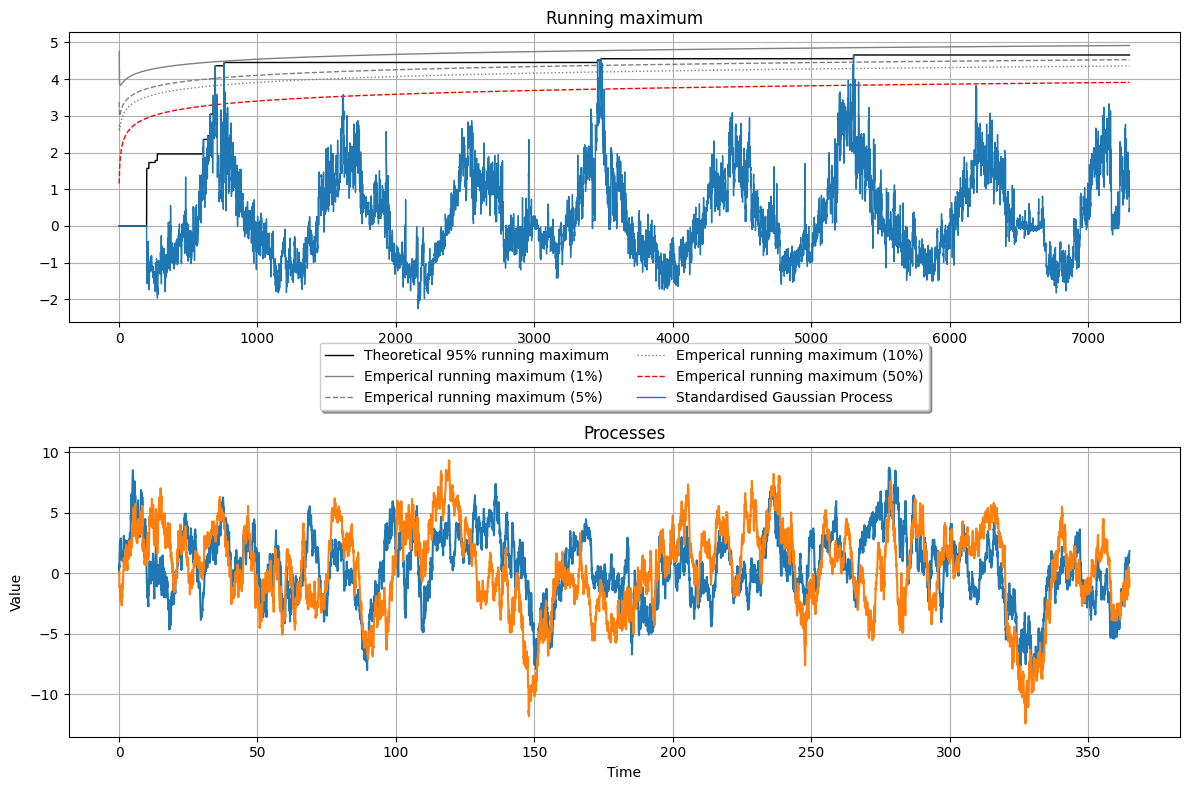

In [43]:
plotting_lib = graph(stationarity_test)
plotting_lib.plot_running_maximum()

In [25]:
@staticmethod
def mu(x,t): return nh_process.mu(x,t)
@staticmethod
def sigm(t): return nh_process.sigm(t)

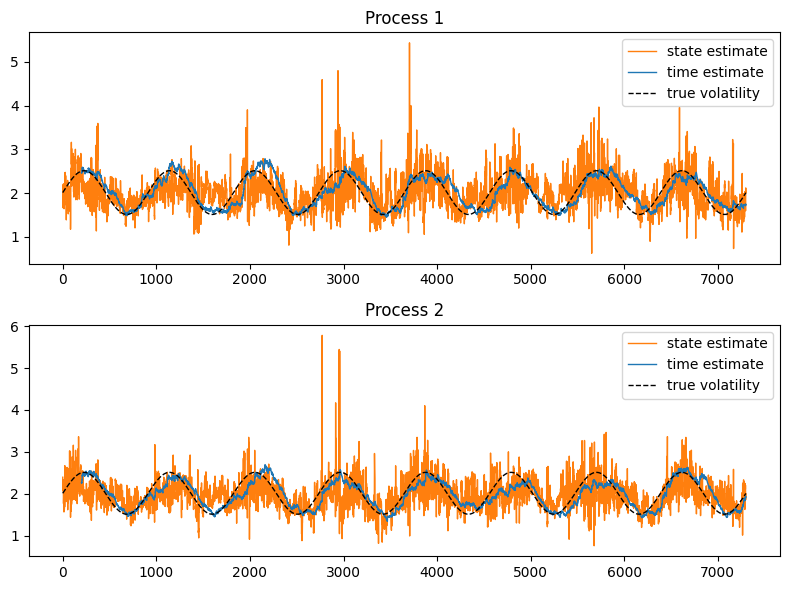

In [26]:
est_time = stationarity_test.time_estimates['estimate']
var_time = stationarity_test.time_estimates['variance']

est_state = stationarity_test.kernel_estimates['estimate']
var_state = stationarity_test.kernel_estimates['variance']

fig, axs = plt.subplots(2,1, figsize = (8,6))
axs[0].plot([item.item(0) ** .5 for item in est_state], c = 'C1', ls = '-', lw = 1, label = 'state estimate')
# plt.plot([item.item(1) ** .5 for item in est_state], c = 'C1', ls = 'dashed', lw = 1)
axs[1].plot([item.item(3) ** .5 for item in est_state], c = 'C1', ls = '-', lw = 1, label = 'state estimate')
axs[0].plot([item.item(0) ** .5 for item in est_time], c = 'C0', ls = '-', lw = 1, label = 'time estimate')
axs[0].plot([sigm(t) for t in np.arange(0, T, T / n)], c = 'black', ls = 'dashed', lw = 1, label = 'true volatility')
# plt.plot([item.item(1) ** .5 for item in est_time], c = 'C0', ls = 'dashed', lw = 1)
axs[1].plot([item.item(3) ** .5 for item in est_time], c = 'C0', ls = '-', lw = 1, label = 'time estimate')
axs[1].plot([sigm(t) for t in np.arange(0, T, T / n)], c = 'black', ls = 'dashed', lw = 1, label = 'true volatility')
axs[0].set_title('Process 1')
axs[1].set_title('Process 2')
for ax in axs: ax.legend()
fig.tight_layout()
plt.show()

# Simulation
We can also run multiple tests to check for the sample properties

In [13]:
# We can supply a seed in order to get the same results under the same settings as to validate the results.
number_of_runs = 200
seed = np.arange(1, number_of_runs + 1, 1).tolist()

In [11]:
def sim(number_of_runs, config, dist, est_config = {}, ProcessGenerator = BivariateOUProcess, save = True, name = 'Simulation', seed = None):
    """
    A simple function to simulate and save data
    """
    if not seed: 
        seed = np.arange(1, number_of_runs + 1, 1).tolist()
        print(f'Custom seed set: [1, ..., {number_of_runs}] (global.standard.standard_seed)')
    simulator = simulate(
        number_of_runs=number_of_runs, 
        config = config,
        est_config = est_config,
        ProcessGenerator = ProcessGenerator
        )
    simulator.run(show_object = False, disable = True, seed = seed, time_kwargs = {'lamb':.99}, state_kwargs={'dist':dist})
    simulator.plot_results()
    simulator.summary(alphas = [.90,.95,.99])

    if save:
        df_process = pd.DataFrame()
        df_gauss = pd.DataFrame()

        for key, val in simulator.results.items():
            if key != 'bound':
                df_process[[key + '_1', key + '_2']] = val['process']
                df_gauss[key] = val['gauss']
        df_process.to_csv('Simulations\\{}_{}_process_{}_{}.csv'.format(name, ProcessGenerator.__name__, number_of_runs, config.get('T')))
        df_gauss.to_csv('Simulations\\{}_{}_gauss_{}_{}.csv'.format(name, ProcessGenerator.__name__, number_of_runs, config.get('T')))

In [32]:
run_on_call: bool = False # Prevents the already run simulations to run again:

## Simulations:
NOTE: the simulations are of complexity $O(n\log n)$ and so total running time takes between 12 to 24 hours, depending on the capacity and power of the machine.

#### Simulation for the Ornstein-Uhlenbeck process

In [33]:
if run_on_call:
    ou_config_50 = {'T':50, 'dt': 1 / 20, 'sigma1': np.sqrt(2), 'sigma2': np.sqrt(2), 'theta1':.2, 'theta2':.2, 'rho':.75}
    sim(number_of_runs, ou_config_50, True, ProcessGenerator = BivariateOUProcess)

    ou_config_150 = {'T':150, 'dt': 1 / 20, 'sigma1': np.sqrt(2), 'sigma2': np.sqrt(2), 'theta1':.2, 'theta2':.2, 'rho':.75}
    sim(number_of_runs, ou_config_150, True, ProcessGenerator = BivariateOUProcess)

    ou_config_365 = {'T':365, 'dt': 1 / 20, 'sigma1': np.sqrt(2), 'sigma2': np.sqrt(2), 'theta1':.2, 'theta2':.2, 'rho':.75}
    sim(number_of_runs, ou_config_365, True, ProcessGenerator = BivariateOUProcess, name = 'SubSimulation')

#### Simulation for the planar $(\tilde{\mathcal{F}}_t)_{t\geq 0}$-Brownian motion process

In [34]:
if run_on_call:
    bw_config_50 = {'T': 50, 'dt': 0.05, 'mu1': 0.0, 'mu2': 0.0, 'rho': 0.0, 'sigma1': 1, 'sigma2': 1}
    dist = (np.ones(int(bw_config_50['T'] / bw_config_50['dt'])) / 50).tolist()
    sim(number_of_runs, bw_config_50, dist, ProcessGenerator = BivariateCorrelatedBM)

    bw_config_150 = {'T': 150, 'dt': 0.05, 'mu1': 0.0, 'mu2': 0.0, 'rho': 0.0, 'sigma1': 1, 'sigma2': 1}
    dist = (np.ones(int(bw_config_150['T'] / bw_config_150['dt'])) / 50).tolist()
    sim(number_of_runs, bw_config_150, dist, ProcessGenerator = BivariateCorrelatedBM)

    bw_config_365 = {'T': 365, 'dt': 0.05, 'mu1': 0.0, 'mu2': 0.0, 'rho': 0.0, 'sigma1': 1, 'sigma2': 1}
    dist = (np.ones(int(bw_config_365['T'] / bw_config_365['dt'])) / 50).tolist()
    sim(number_of_runs, bw_config_365, dist, ProcessGenerator = BivariateCorrelatedBM)


#### Simulation for the Inhomogeneous diffusion process

In [35]:
if run_on_call:    
    nh_config_50 = {'T': 50, 'dt': 0.05, 'rho': 0.5, 'alpha': 0.3, 'b': 0.01}
    sim(number_of_runs, nh_config_50, dist, ProcessGenerator = BivariateNonHomogeneous)

    nh_config_150 = {'T': 150, 'dt': 0.05, 'rho': 0.5, 'alpha': 0.3, 'b': 0.01}
    sim(number_of_runs, nh_config_150, False, ProcessGenerator = BivariateNonHomogeneous)

    nh_config_365 = {'T': 365, 'dt': 0.05, 'rho': 0.5, 'alpha': 0.3, 'b': 0.01}
    sim(number_of_runs, nh_config_365, dist, ProcessGenerator = BivariateNonHomogeneous)


Custom seed set: [1, ..., 200] (global.standard.standard_seed)
number_of_runs :: 200
config
         T :: 50
        dt :: 0.05
       rho :: 0.5
     alpha :: 0.5
         b :: 0.1
est_config
ProcessGenerator :: <class 'core.models.BivariateNonHomogeneous'>
results
Simulation started on custom seed.


100%|██████████| 200/200 [09:01<00:00,  2.71s/it]


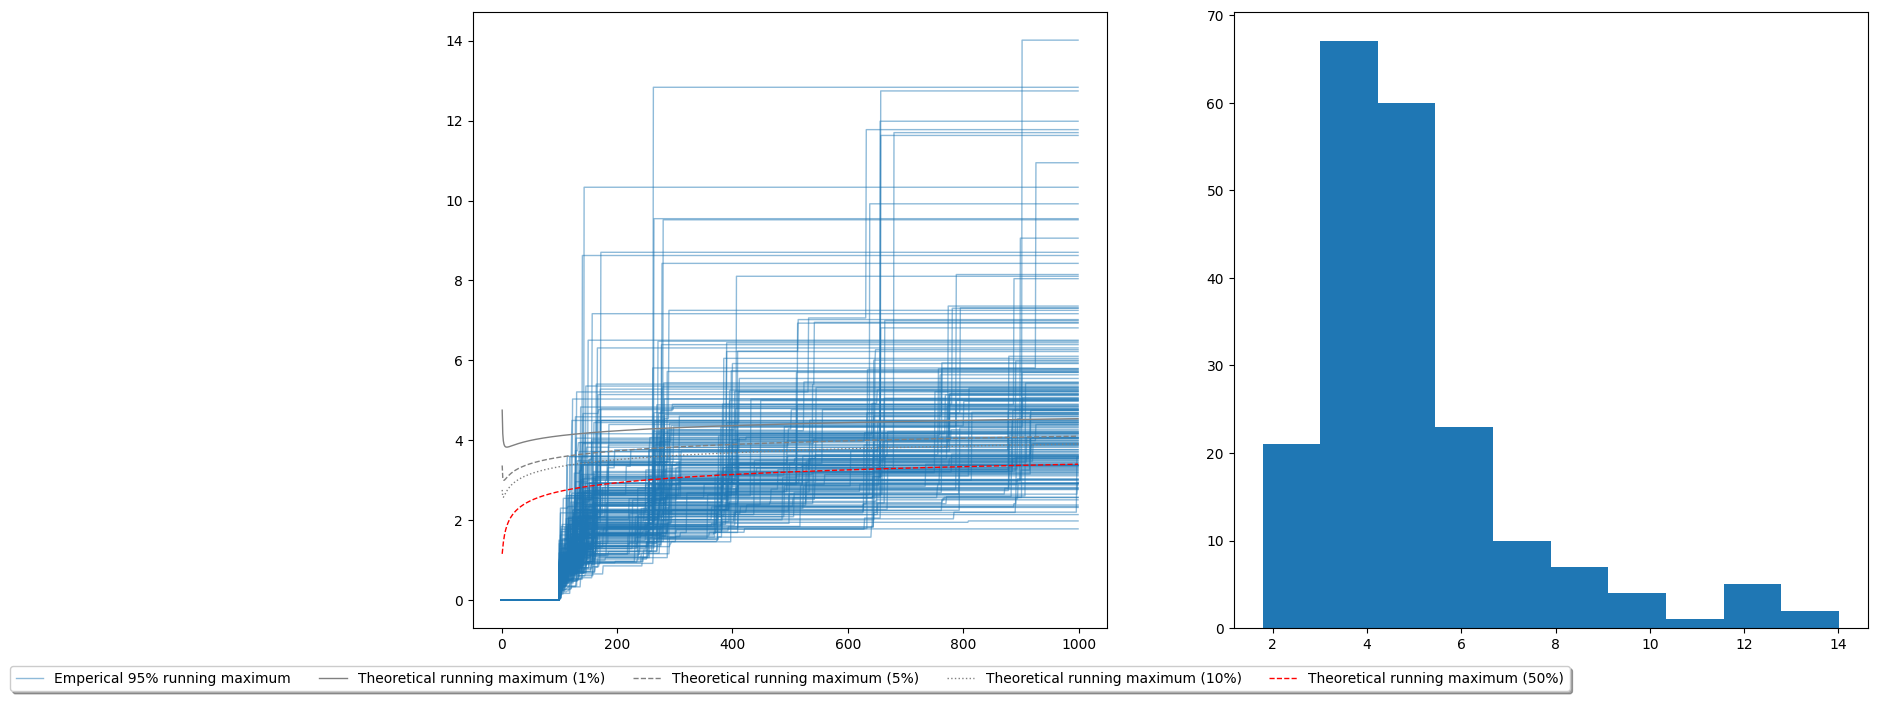

Number of runs: 200, rejection rate: 66.5% (α = 90.0%)
Number of runs: 200, rejection rate: 60.0% (α = 95.0%)
Number of runs: 200, rejection rate: 49.5% (α = 99.0%)
Custom seed set: [1, ..., 200] (global.standard.standard_seed)
number_of_runs :: 200
config
         T :: 150
        dt :: 0.05
       rho :: 0.5
     alpha :: 0.5
         b :: 0.1
est_config
ProcessGenerator :: <class 'core.models.BivariateNonHomogeneous'>
results
Simulation started on custom seed.


100%|██████████| 200/200 [37:54<00:00, 11.37s/it]


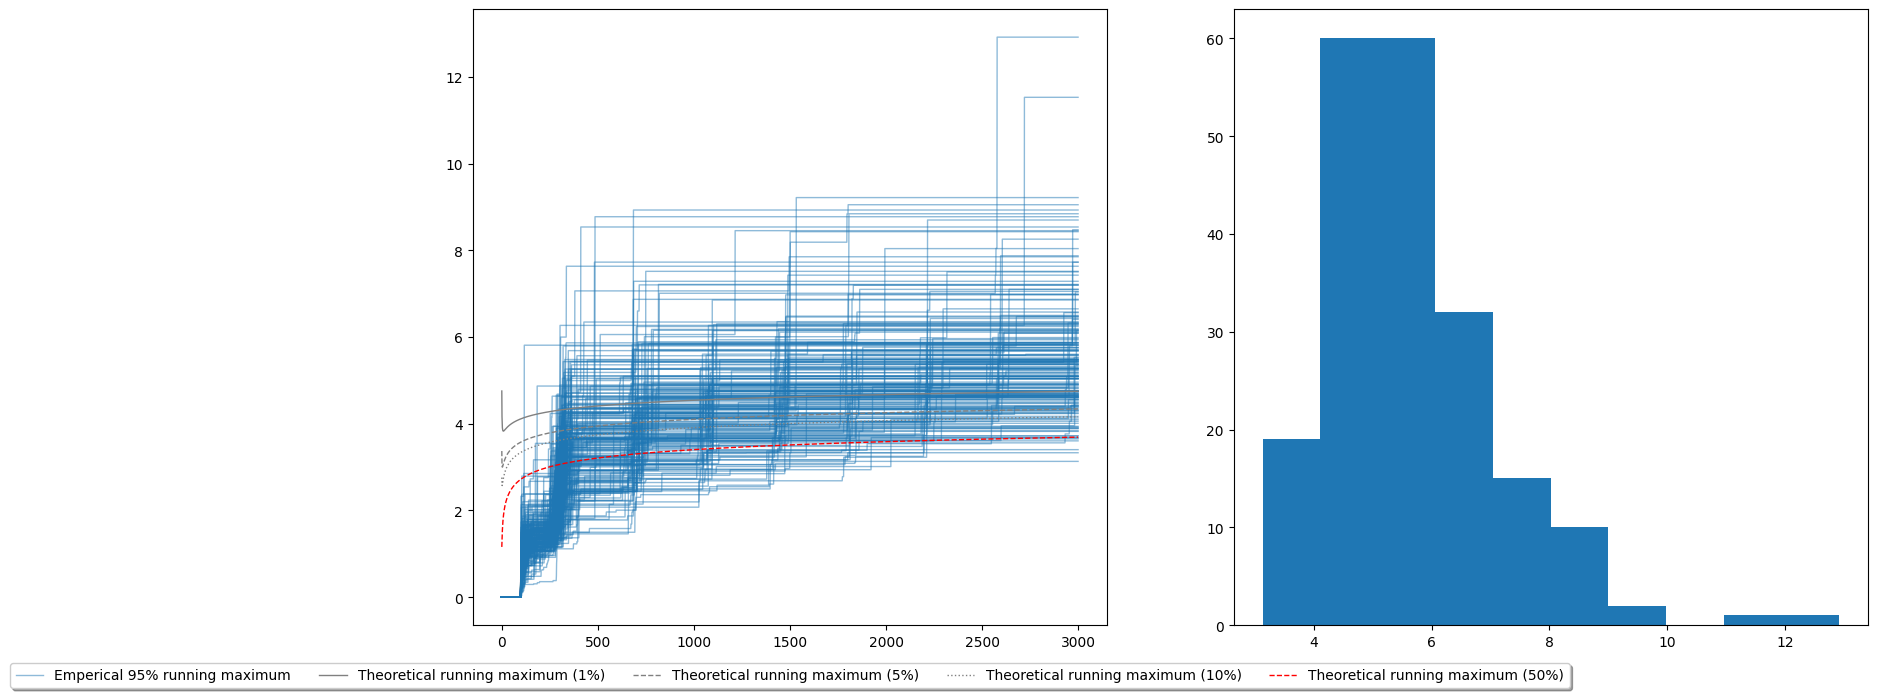

Number of runs: 200, rejection rate: 90.0% (α = 90.0%)
Number of runs: 200, rejection rate: 86.5% (α = 95.0%)
Number of runs: 200, rejection rate: 70.5% (α = 99.0%)
Custom seed set: [1, ..., 200] (global.standard.standard_seed)
number_of_runs :: 200
config
         T :: 365
        dt :: 0.05
       rho :: 0.5
     alpha :: 0.5
         b :: 0.1
est_config
ProcessGenerator :: <class 'core.models.BivariateNonHomogeneous'>
results
Simulation started on custom seed.


100%|██████████| 200/200 [2:07:17<00:00, 38.19s/it]  


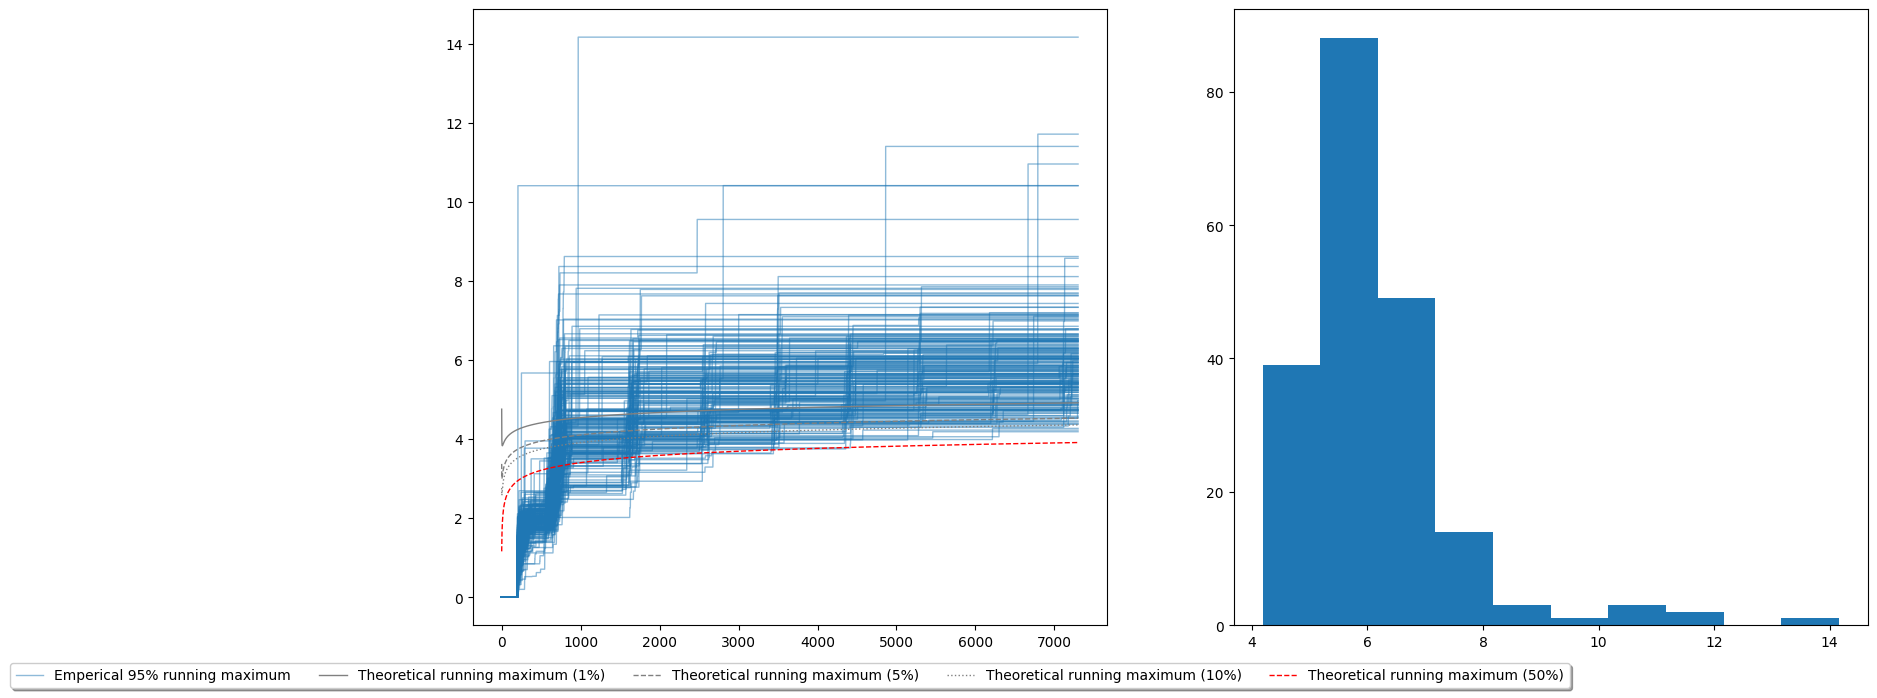

Number of runs: 200, rejection rate: 98.5% (α = 90.0%)
Number of runs: 200, rejection rate: 96.0% (α = 95.0%)
Number of runs: 200, rejection rate: 87.0% (α = 99.0%)


In [44]:
if run_on_call:     
    nh_config_50 = {'T': 50, 'dt': 0.05, 'rho': 0.5, 'alpha': 0.5, 'b': 0.1}
    sim(number_of_runs, nh_config_50, True, ProcessGenerator = BivariateNonHomogeneous, name = 'SubSimulation_dist')

    nh_config_150 = {'T': 150, 'dt': 0.05, 'rho': 0.5, 'alpha': 0.5, 'b': 0.1}
    sim(number_of_runs, nh_config_150, True, ProcessGenerator = BivariateNonHomogeneous, name = 'SubSimulation_dist')

    nh_config_365 = {'T': 365, 'dt': 0.05, 'rho': 0.5, 'alpha': 0.5, 'b': 0.1}
    sim(number_of_runs, nh_config_365, True, ProcessGenerator = BivariateNonHomogeneous, name = 'SubSimulation_dist')

##### We can also call the Benjamini-Hochberg-Yekutieli method using the `core.MultipleHypTest.MultipleHypTest(...)` class

To do so, we call on the stores simulation results, located at ..\\\\data\\\\simulation_file_name.csv.

In [4]:
files: list = [
    # Bivariate Ornstein-Uhlenbeck process for k = 50, 150 and 365
    '\\Simulation_BivariateOUProcess_gauss_200_50.csv',
    '\\Simulation_BivariateOUProcess_gauss_200_150.csv',
    '\\SubSimulation_BivariateOUProcess_gauss_200_365.csv',
    # '\\Simulation_BivariateOUProcess_process_200_50.csv',
    # '\\Simulation_BivariateOUProcess_process_200_150.csv',
    # '\\Simulation_BivariateOUProcess_process_200_365.csv',

    # Bivariate correlated Brownian motion for k = 50, 150 and 365
    '\\Simulation_BivariateCorrelatedBM_gauss_200_50.csv',
    '\\Simulation_BivariateCorrelatedBM_gauss_200_150.csv',
    '\\Simulation_BivariateCorrelatedBM_gauss_200_365.csv',
    # '\\Simulation_BivariateCorrelatedBM_process_200_50.csv',
    # '\\Simulation_BivariateCorrelatedBM_process_200_150.csv',
    # '\\Simulation_BivariateCorrelatedBM_process_200_365.csv',

    # Bivariate inhomogeneous diffusion for k = 50, 150 and 365
    '\\SubSimulation_dist_BivariateNonHomogeneous_gauss_200_50.csv',
    '\\SubSimulation_dist_BivariateNonHomogeneous_gauss_200_150.csv',
    '\\SubSimulation_dist_BivariateNonHomogeneous_gauss_200_365.csv',
    # '\\SubSimulation_dist_BivariateNonHomogeneous_process_200_50.csv',
    # '\\SubSimulation_dist_BivariateNonHomogeneous_process_200_150.csv',
    # '\\SubSimulation_dist_BivariateNonHomogeneous_process_200_365.csv',
       ]

In [5]:
# Download content using the Reader module
content = Reader(files = files)

100%|██████████| 9/9 [00:01<00:00,  5.10it/s]


In [8]:
# Loop over files to run running maximum replication
for file in files:
    name = file.replace('_dist','').split('_')[1]
    file = file.replace('\\','')
    repl(content.parsed_files[file], name).summary()

------------------------- BivariateOUProcess -------------------------
Number of runs: 200, rejection rate: 14.0% (α = 90.0%)
Number of runs: 200, rejection rate: 12.5% (α = 95.0%)
Number of runs: 200, rejection rate: 7.5% (α = 99.0%)

------------------------- BivariateOUProcess -------------------------
Number of runs: 200, rejection rate: 10.0% (α = 90.0%)
Number of runs: 200, rejection rate: 7.5% (α = 95.0%)
Number of runs: 200, rejection rate: 5.0% (α = 99.0%)

------------------------- BivariateOUProcess -------------------------
Number of runs: 200, rejection rate: 6.0% (α = 90.0%)
Number of runs: 200, rejection rate: 4.5% (α = 95.0%)
Number of runs: 200, rejection rate: 4.0% (α = 99.0%)

----------------------- BivariateCorrelatedBM ------------------------
Number of runs: 200, rejection rate: 36.5% (α = 90.0%)
Number of runs: 200, rejection rate: 32.0% (α = 95.0%)
Number of runs: 200, rejection rate: 23.5% (α = 99.0%)

----------------------- BivariateCorrelatedBM ------------

In [9]:
# Loop over the files to run the Benjamini-Hochberg-Yekutieli procedures
# For sake of brevity, we will only show the results of the OU-process.
for file in files[:1]:
    name = file.replace('_dist','').split('_')[1]
    MultipleHypTest(content.parsed_files[file.replace('\\','')], run_on_call = True, name = name)

------------------------- BivariateOUProcess -------------------------
MultipleHypTest@Self.run: running [hochberg]...


200it [00:16, 12.20it/s]
200it [00:19, 10.31it/s]
200it [00:17, 11.48it/s]



Hochberg:
Rejection rate: 14.00% (α = 10.00%)
Rejection rate: 13.00% (α =  5.00%)
Rejection rate: 10.00% (α =  1.00%)

MultipleHypTest@Self.run: running [yekutieli]...


200it [00:16, 12.26it/s]
200it [00:17, 11.20it/s]
200it [00:18, 11.01it/s]


Yekutieli:
Rejection rate: 10.00% (α = 10.00%)
Rejection rate:  8.00% (α =  5.00%)
Rejection rate:  6.00% (α =  1.00%)

-------------------------------Finished-------------------------------


In [15]:
# The class can also be called using a single file
X = content.parsed_files['Simulation_BivariateCorrelatedBM_gauss_200_150.csv']
bhy_test = MultipleHypTest(X, two_sides = True, remove_zero_rows = True)

In [16]:
# Then, simply call the run method to start the procedure for both methods
bhy_test.run()  # standard sign. values are .1, .05 and .01

MultipleHypTest@Self.run: running [hochberg]...


200it [00:55,  3.59it/s]
200it [00:55,  3.64it/s]
200it [00:53,  3.75it/s]



Hochberg:
Rejection rate: 84.00% (α = 10.00%)
Rejection rate: 84.00% (α =  5.00%)
Rejection rate: 74.00% (α =  1.00%)

MultipleHypTest@Self.run: running [yekutieli]...


200it [00:59,  3.38it/s]
200it [00:55,  3.62it/s]
200it [00:48,  4.08it/s]


Yekutieli:
Rejection rate: 74.00% (α = 10.00%)
Rejection rate: 71.00% (α =  5.00%)
Rejection rate: 62.00% (α =  1.00%)

-------------------------------Finished-------------------------------
